# Learning:
1. Metrics: Matthews Correlation Coefficient (MCC)
2. AutoML: LightAutoML

### LightAutoML
- https://lightautoml.readthedocs.io/en/latest/index.html
- https://paperswithcode.com/method/lightautoml
- https://arxiv.org/pdf/2109.01528

LightAutoML provides easy-to-use pipeline creation, that enables:
- Automatic hyperparameter tuning, data processing.
- Automatic typing, feature selection.
- Automatic time utilization.
- Automatic report creation.
- Easy-to-use modular scheme to create your own pipelines.

In [1]:
import os

os.chdir('/home/ubuntu/kaggle/mushroom-binary-classifier')

In [2]:
import polars as pl

train_df = pl.scan_csv("train.csv")

In [3]:
train_df.head().collect()

id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
i64,str,f64,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str
0,"""e""",8.8,"""f""","""s""","""u""","""f""","""a""","""c""","""w""",4.51,15.39,null,null,"""w""",null,null,"""f""","""f""",null,"""d""","""a"""
1,"""p""",4.51,"""x""","""h""","""o""","""f""","""a""","""c""","""n""",4.79,6.48,null,"""y""","""o""",null,null,"""t""","""z""",null,"""d""","""w"""
2,"""e""",6.94,"""f""","""s""","""b""","""f""","""x""","""c""","""w""",6.85,9.93,null,"""s""","""n""",null,null,"""f""","""f""",null,"""l""","""w"""
3,"""e""",3.88,"""f""","""y""","""g""","""f""","""s""",null,"""g""",4.16,6.53,null,null,"""w""",null,null,"""f""","""f""",null,"""d""","""u"""
4,"""e""",5.85,"""x""","""l""","""w""","""f""","""d""",null,"""w""",3.37,8.36,null,null,"""w""",null,null,"""f""","""f""",null,"""g""","""a"""


In [4]:
train_df.select(pl.col('class').value_counts(normalize=True)).collect()

class
struct[2]
"{""e"",0.452863}"
"{""p"",0.547137}"


In [5]:
train_df.null_count().collect()

id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,4,40,671023,12,8,523936,1258435,57,0,0,2757023,1980861,38,2957493,2740947,24,128880,2849682,45,0


In [6]:
import requests

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import train_test_split
import torch

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [7]:
train_df.columns

/tmp/ipykernel_6052/1442268148.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  train_df.columns


['id',
 'class',
 'cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [8]:
N_THREADS = 4 # number of vCPUs for lightAutoML model creation
N_FOLDS = 5 # number of folds for LightAutoML inner CV
RANDOM_STATE = 42 # random state for reproducibility
TEST_SIZE = 0.2 # hold out part size for splitting data
TIMEOUT = 3600 # limit in seconds for model training
TARGET_NAME = 'class' # target column name

In [9]:
DATASET_NAME = "train.csv"

In [10]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [8]:
# data = pd.read_csv(DATASET_NAME)
# data.head()

In [11]:
data = train_df.collect().to_pandas()

<Axes: >

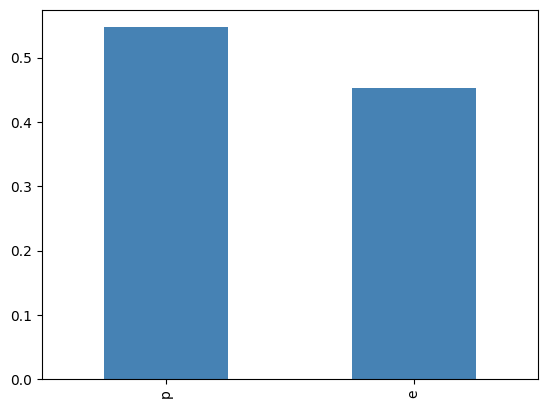

In [15]:
data['class'].value_counts(dropna=False, normalize=True).plot(kind='bar', color='steelblue')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [14]:
train_data, test_data = train_test_split(
    data,
    test_size=TEST_SIZE,
    stratify=data[TARGET_NAME],
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

Data is splitted. Parts sizes: train_data = (2493556, 22), test_data = (623389, 22)


In [16]:
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
586767,586767,p,4.95,x,None,p,f,None,c,w,...,None,None,y,None,None,f,f,None,d,a
2665706,2665706,p,1.47,b,y,n,f,None,c,k,...,None,None,w,None,None,f,f,None,d,u
1270574,1270574,e,10.29,x,e,l,f,x,c,w,...,None,None,w,None,None,f,f,None,d,a
2935630,2935630,p,7.45,s,d,n,t,d,c,n,...,None,None,e,None,None,f,f,None,d,a
3113991,3113991,p,5.44,x,None,e,f,None,c,r,...,None,None,y,None,None,f,f,None,d,a


<Axes: >

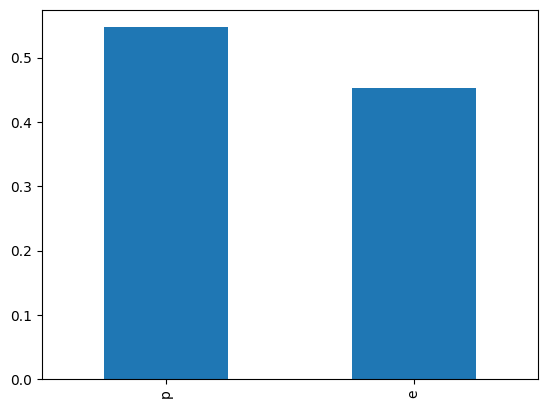

In [18]:
train_data[TARGET_NAME].value_counts(normalize=True, dropna=False).plot(kind='bar')

In [19]:
task = Task('binary')

Unfortunately there is no mcc in avalilable metrics:
- ‘auc’ - (uses by default) ROC-AUC score.
- ‘accuracy’ - Accuracy score (uses argmax prediction).
- ‘logloss’ - Standard logistic loss.

In [20]:
roles = {
    'target': TARGET_NAME,
    'drop': ['id']
}

In [18]:
automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [19]:
%%time
out_of_fold_predictions = automl.fit_predict(train_data, roles=roles, verbose=1)

[14:48:19] Stdout logging level is INFO.
[14:48:19] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[14:48:19] Task: binary

[14:48:19] Start automl preset with listed constraints:
[14:48:19] - time: 3600.00 seconds
[14:48:19] - CPU: 4 cores
[14:48:19] - memory: 16 GB

[14:48:19] Train data shape: (2493556, 22)

[14:48:36] Layer 1 train process start. Time left 3583.13 secs
[14:50:00] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:54:58] Time limit exceeded after calculating fold 1

[14:54:59] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9491542367487322
[14:54:59] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[14:54:59] Time left 3200.68 secs

[14:56:38] Selector_LightGBM fitting and predicting completed
[14:58:31] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[15:03:01] Time limit exceeded after calculating fold 1

[15:03:01] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9970172952911046
[15:03:

In [20]:
%%time

test_predictions = automl.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[0.99450445],
       [0.99274296],
       [0.9952512 ],
       ...,
       [0.99438167],
       [0.98908454],
       [0.00502333]], dtype=float32)
Shape = (623389, 1)
CPU times: user 3min 49s, sys: 693 ms, total: 3min 49s
Wall time: 1min 9s


In [34]:
automl.get_config()

{'general_params': {'use_algos': 'auto',
  'nested_cv': False,
  'skip_conn': True,
  'return_all_predictions': False,
  'weighted_blender_max_nonzero_coef': 0.05},
 'reader_params': {'samples': 100000,
  'max_nan_rate': 0.999,
  'max_constant_rate': 0.999,
  'cv': 5,
  'random_state': 42,
  'roles_params': None,
  'n_jobs': 8,
  'advanced_roles': True,
  'numeric_unique_rate': 0.999,
  'max_to_3rd_rate': 1.1,
  'binning_enc_rate': 2,
  'raw_decr_rate': 1.1,
  'max_score_rate': 0.2,
  'abs_score_val': 0.04,
  'drop_score_co': 0.0},
 'read_csv_params': {'decimal': '.', 'sep': ','},
 'nested_cv_params': {'cv': 5,
  'n_folds': None,
  'inner_tune': False,
  'refit_tuner': True},
 'selection_params': {'mode': 1,
  'importance_type': 'gain',
  'fit_on_holdout': True,
  'cutoff': 0,
  'feature_group_size': 1,
  'max_features_cnt_in_result': None,
  'select_algos': ['gbm']},
 'tuning_params': {'fit_on_holdout': True,
  'max_tuning_iter': 101,
  'max_tuning_time': 300},
 'lgb_params': {'defaul

In [22]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

OOF score: 0.002939218956128139
HOLDOUT score: 0.0027796972715918664


In [23]:
out_of_fold_predictions.data[]

array([[0.0039817 ],
       [0.98914045],
       [0.99698055],
       ...,
       [0.99583554],
       [0.9968535 ],
       [0.995476  ]], dtype=float32)

In [35]:
automl.predict(test_data, features_names='predictions', return_all_predictions=True)

array([[0.99567825, 0.9947729 , 0.99187505],
       [0.99407727, 0.99340695, 0.9893171 ],
       [0.9953694 , 0.994633  , 0.99577194],
       ...,
       [0.9945405 , 0.9935221 , 0.9951161 ],
       [0.9885213 , 0.9900485 , 0.9890156 ],
       [0.00494316, 0.0053453 , 0.00478861]], dtype=float32)

In [24]:
train_data[TARGET_NAME].values

array(['p', 'p', 'e', ..., 'e', 'e', 'e'], dtype=object)

In [27]:
out_of_fold_predictions

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

In [28]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.46941 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.29131 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.23929 * (1 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


---

In [21]:
RD = ReportDeco(output_path='tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task=task,
        timeout=TIMEOUT,
        cpu_limit=N_THREADS,
        reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [22]:
roles

{'target': 'class', 'drop': ['id']}

In [23]:
%%time
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles=roles, verbose=1)

[10:41:36] Stdout logging level is INFO.
[10:41:36] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[10:41:36] Task: binary

[10:41:36] Start automl preset with listed constraints:
[10:41:36] - time: 3600.00 seconds
[10:41:36] - CPU: 4 cores
[10:41:36] - memory: 16 GB

[10:41:36] Train data shape: (2493556, 22)

[10:41:54] Layer 1 train process start. Time left 3582.55 secs
[10:43:27] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:46:10] Time limit exceeded after calculating fold 0

[10:46:10] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9493398730989631
[10:46:10] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[10:46:10] Time left 3325.78 secs

[10:47:57] Selector_LightGBM fitting and predicting completed
[10:49:55] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[10:54:40] Time limit exceeded after calculating fold 1

[10:54:41] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9970172952911046
[10:54:

TypeError: unsupported operand type(s) for -: 'int' and 'str'